In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
import tensorflow as tf

In [25]:
tf.__version__

'2.13.1'

In [26]:
df_2021 = pd.read_csv("estadisticas_partidos_2021.csv")
df_2022 = pd.read_csv("estadisticas_partidos_2022.csv")
df_2023 = pd.read_csv("estadisticas_partidos_2023.csv")

df_2021 = df_2021.sort_index(axis=0, ascending=False, ignore_index=True) # Porque es el único que está de más viejo a nuevo.


In [27]:
df = df_2023.merge(df_2022, how='outer').merge(df_2021, how="outer")
cantidad_nan_por_columna = df.isna().sum()

drop = ["round", "expected_goals_home", "expected_goals_away", "throw_ins_home", "throw_ins_away",
        "hit_woodwork_home", "hit_woodwork_away", "counter_attacks_home", "counter_attacks_away",
        "counter_attacks_shots_home","counter_attacks_shots_away","possesion_lost_home","possesion_lost_away",
        "clearences_home","clearences_away","number_of_match"]
df = df.drop_duplicates().drop(drop, axis=1).fillna(method="backfill")
df = df.sort_index(axis=0, ascending=False, ignore_index=True)


C:\Users\gfuen\AppData\Local\Temp\ipykernel_15308\2732399485.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.drop_duplicates().drop(drop, axis=1).fillna(method="backfill")


In [28]:
df.head()

,team_home,team_away,home_score,away_score,posession_home,posession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,...,dribbles_home,dribbles_away,duels_won_home,duels_won_away,aerials_won_home,aerials_won_away,tackles_home,tackles_away,interceptions_home,interceptions_away
0,Deportes Copiapó,Huachipato,2,3,56.0,44.0,14.0,11.0,6.0,7.0,...,3.0,14.0,37.0,54.0,8.0,9.0,13.0,16.0,6.0,5.0
1,Huachipato,Deportes Copiapó,1,0,55.0,45.0,8.0,7.0,2.0,1.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
2,Temuco,Deportes Copiapó,1,0,62.0,38.0,9.0,3.0,6.0,1.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
3,Deportes Copiapó,Temuco,3,1,58.0,42.0,11.0,7.0,6.0,2.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
4,CD Antofagasta,Colo Colo,1,0,38.0,62.0,3.0,13.0,1.0,1.0,...,11.0,12.0,61.0,59.0,11.0,9.0,30.0,19.0,12.0,9.0


In [29]:
#Por comodidad
df.rename(columns={'home_score': 'score_home',"away_score":"score_away"}, inplace=True)

In [30]:
df.head()

,team_home,team_away,score_home,score_away,posession_home,posession_away,total_shots_home,total_shots_away,shots_on_target_home,shots_on_target_away,...,dribbles_home,dribbles_away,duels_won_home,duels_won_away,aerials_won_home,aerials_won_away,tackles_home,tackles_away,interceptions_home,interceptions_away
0,Deportes Copiapó,Huachipato,2,3,56.0,44.0,14.0,11.0,6.0,7.0,...,3.0,14.0,37.0,54.0,8.0,9.0,13.0,16.0,6.0,5.0
1,Huachipato,Deportes Copiapó,1,0,55.0,45.0,8.0,7.0,2.0,1.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
2,Temuco,Deportes Copiapó,1,0,62.0,38.0,9.0,3.0,6.0,1.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
3,Deportes Copiapó,Temuco,3,1,58.0,42.0,11.0,7.0,6.0,2.0,...,10.0,11.0,56.0,60.0,21.0,13.0,9.0,18.0,13.0,14.0
4,CD Antofagasta,Colo Colo,1,0,38.0,62.0,3.0,13.0,1.0,1.0,...,11.0,12.0,61.0,59.0,11.0,9.0,30.0,19.0,12.0,9.0


In [31]:
home_win = 0
away_win = 0
draw = 0
for i in range(len(df)):
    if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
        home_win +=1
    elif df.iloc[i]["score_away"] > df.iloc[i]["score_home"]:
        away_win +=1
    elif df.iloc[i]["score_away"] == df.iloc[i]["score_home"]:
        draw +=1
    df.iloc[i]['duels_won_home'] > df.iloc[i]['duels_won_away']

total = len(df)
home_win_percentage = home_win/total
away_win_percentage = away_win/total
draw_perentage = draw/total

In [32]:
print(home_win_percentage)
print(away_win_percentage)
print(draw_perentage)

0.42894736842105263
0.30526315789473685
0.2657894736842105


In [33]:
df.columns

Index(['team_home', 'team_away', 'score_home', 'score_away', 'posession_home',
       'posession_away', 'total_shots_home', 'total_shots_away',
       'shots_on_target_home', 'shots_on_target_away', 'shots_off_target_home',
       'shots_off_target_away', 'blocked_shots_home', 'blocked_shots_away',
       'corner_kicks_home', 'corner_kicks_away', 'offsides_home',
       'offsides_away', 'fouls_home', 'fouls_away', 'yellow_cards_home',
       'yellow_cards_away', 'red_cards_home', 'red_cards_away',
       'free_kicks_home', 'free_kicks_away', 'goal_kicks_home',
       'goal_kicks_away', 'big_chances_home', 'big_chances_away',
       'big_chances_missed_home', 'big_chances_missed_away',
       'shots_inside_box_home', 'shots_inside_box_away',
       'shots_outside_box_home', 'shots_outside_box_away',
       'goalkeeper_saves_home', 'goalkeeper_saves_away', 'passes_home',
       'passes_away', 'accurate_passes_home', 'accurate_passes_away',
       'long_balls_home', 'long_balls_away', 'cr

In [34]:
def get_features(data, side):
    if side == "home":
        return data[2:].values
    elif side == "away": 
        original_lista = data.keys()[2:]
        nueva_lista = [item.replace('home', 'temp').replace('away', 'home').replace('temp', 'away') for item in original_lista]
        return data.get(nueva_lista).values


In [35]:
def search_features(i, df, last_games):
    # W = home_win, D = draw, L = home_lose
    team_home = df.iloc[i]["team_home"]
    team_away = df.iloc[i]["team_away"]
    home_search = last_games
    away_search = last_games
    # W = win, D = draw, L = lose
    info_home = []
    info_away = []
    info_features_home = []
    info_features_away = []
    df_match1 = df[df["team_home"] == team_home]
    df_match2 = df[df["team_away"] == team_home]
    df_match3 = df[df["team_home"] == team_away]
    df_match4 = df[df["team_away"] == team_away]
    df_match_index = sorted(list(set(df_match1.index) | set(df_match2.index) | set(
        df_match3.index) | set(df_match4.index)), reverse=True)
    for j in df_match_index:

        if away_search == 0 and home_search == 0:
            features_home_games = np.sum(info_features_home, axis=0)/last_games
            features_away_games = np.sum(info_features_away, axis=0)/last_games
            # features_home_games = np.concatenate(info_features_home)
            # features_away_games = np.concatenate(info_features_away)
            if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
                result = "W"
            elif df.iloc[i]["score_home"] == df.iloc[i]["score_away"]:
                result = "D"
            elif df.iloc[i]["score_home"] < df.iloc[i]["score_away"]:
                result = "L"
            return info_home, info_away, result, features_home_games, features_away_games
        # Buscamos los partidos anteriores del equipo de CASA

        if home_search > 0 and i-j > 0:
            if team_home == df.iloc[j]["team_home"]:
                info_features_home.append(
                    get_features(df.iloc[j], side="home"))
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("D")
            elif team_home == df.iloc[j]["team_away"]:
                info_features_home.append(
                    get_features(df.iloc[j], side="away"))
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("D")

        # Buscamos los partidos anteriores del equipo de VISITA
        if away_search > 0 and i-j > 0:
            if team_away == df.iloc[j]["team_home"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="home"))
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("D")
            elif team_away == df.iloc[j]["team_away"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="away"))
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("D")

In [45]:
last_games = 3
num_trabajadores = -1
resultados = Parallel(n_jobs=num_trabajadores,verbose=10)(
    delayed(search_features)(i, df, last_games) for i in range(len(df)))
resultados_limpios = []
for i in range(len(resultados)):
    if resultados[i] != None:
        resultados_limpios.append(resultados[i])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1934529888227969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.038512468338012695s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.055527448654174805s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.0s
[Parallel(n_jo

In [46]:
len(resultados_limpios)

696

In [47]:
X = []
Y = []

for i in range(len(resultados_limpios)):
    streak_home = resultados_limpios[i][0]
    streak_away = resultados_limpios[i][1]
    result = resultados_limpios[i][2]

    features_home_games = resultados_limpios[i][3]
    features_away_games = resultados_limpios[i][4]

    home_wins = streak_home.count("W")
    home_draws = streak_home.count("D")
    home_lose = streak_home.count("L")

    away_wins = streak_away.count("W")
    away_draws = streak_away.count("D")
    away_lose = streak_away.count("L")

    features = [home_wins, home_draws, home_lose,
                away_wins, away_draws, away_lose,
                *features_home_games, *features_away_games]
    
    # Con factor temporal
    for match in streak_home:
        if match == "W":
            features.extend([1, 0, 0])
        elif match == "D":
            features.extend([0, 1, 0])
        elif match == "L":
            features.extend([0, 0, 1])

    for match in streak_away:
        if match == "W":
            features.extend([1, 0, 0])
        elif match == "D":
            features.extend([0, 1, 0])
        elif match == "L":
            features.extend([0, 0, 1])
    X.append(features)
    if result == "W":
        Y.append([1, 0, 0])
    elif result == "D":
        Y.append([0, 1, 0])
    elif result == "L":
        Y.append([0, 0, 1])

In [48]:
from sklearn import preprocessing
X_array = np.array(X)
scaler = preprocessing.StandardScaler()
X_array_escalado = scaler.fit_transform(X_array)
Y_array = np.array(Y)

In [49]:
len(X_array[0])

132

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_array_escalado, Y_array, test_size=0.2)
drop = 0.1

model = model = models.Sequential()
model.add(layers.InputLayer(input_shape=(len(X[0]),)))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
# # Compilamos el modelo
model.compile(loss='categorical_crossentropy',
              optimizer= "adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=1000, validation_data=(X_test,y_test))

Epoch 1/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.6278 - categorical_accuracy: 0.3147 - val_loss: 1.6502 - val_categorical_accuracy: 0.2857
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 1.4994 - categorical_accuracy: 0.3309 - val_loss: 1.5747 - val_categorical_accuracy: 0.2857
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 1.4043 - categorical_accuracy: 0.3489 - val_loss: 1.5089 - val_categorical_accuracy: 0.2786
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 1.3306 - categorical_accuracy: 0.3723 - val_loss: 1.4543 - val_categorical_accuracy: 0.3000
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 1.2732 - categorical_accuracy: 0.3759 - val_loss: 1.4255 - val_categorical_accuracy: 0.2929
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 1.2305 - categorical_accuracy: 0.3975 - val_loss: 1.4007 - val_categorical_accuracy: 0.2857
Epoc

5/5 [==============================] - 0s 750us/step
Matriz de Confusión:


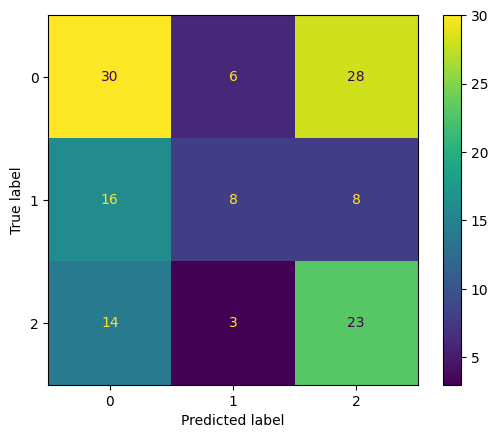

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


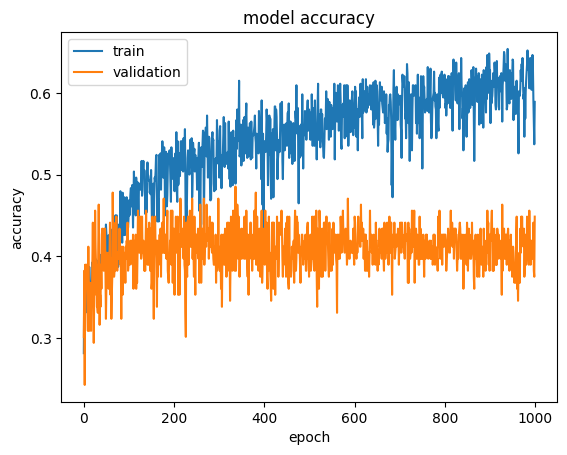

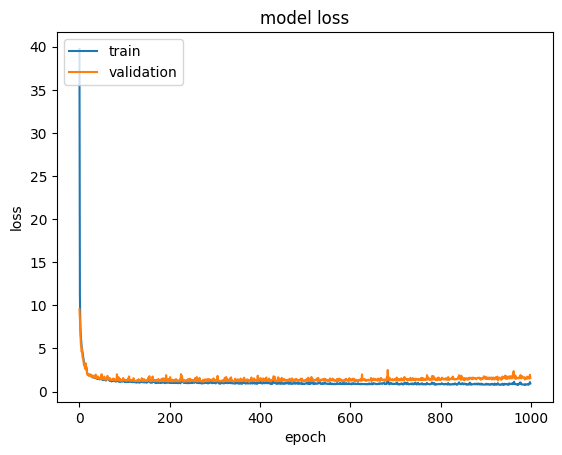

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
print('Matriz de Confusión:')
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [149]:
print(classification_report(y_test_metrics, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.94      0.64        63
           1       0.00      0.00      0.00        32
           2       0.53      0.22      0.31        45

    accuracy                           0.49       140
   macro avg       0.34      0.39      0.32       140
weighted avg       0.39      0.49      0.39       140



c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,